# PDF Journalling Part 1: The Basics

## Introduction
Modern database management systems (DBMS) include journalling facilities. This feature allows logging changes to databases in special files, so-called journals or logfiles.

Long-running applications, updating multiple logically interconnected databases, cannot afford to be restarted from the beginning after crashes happened, like power or hardware failures. This would not only entail repeating previous work, but require prior restoration of all involved databases  - often enough long-running jobs by themselves.

A properly designed application restarted in emergency restart mode will read the logfile, look up the last point at which all involved databases had been in a consistent state (a so-called *checkpoint*), roll back any logged updates thereafter and resume its work from that point on.

MuPDF supports a journalling feature which makes the above DBMS concepts available for updating PDFs.

Applications updating databases may now integrate PDF changes in their checkpoint-restart logic.

But independent from any databases, it is also possible to put incremental updates of a PDF under the control of PDF journalling. Together with the journal file, it is possible to reinstate earlier versions of the document.

A note on terminology:

  * Updates to (SQL) databases are grouped in "Logical Units of Work" (LUWs). Consitent database configurations exist at start and end of a LUW. Writing a checkpoint therefore always happens **after** the end of an LUW - never in between.

  * In MuPDF the term "operation" plays the role of an LUW.

*PDF Journalling is a unique, unequalled feature of PyMuPDF and MuPDF. It allows keeping advanced control over updates to PDF documents, granular undoing changes and an independent way to detect unauthorized changes.*

## Part 1: The Basics
In this notebook you will learn basic concepts of PDF journalling using PyMuPDF:

1. How to activate journalling and define operations

2. How to make and navigate between changes

----------

In [1]:
"""
Notebook preamble code:
Install and import required packages, define image generation utility.
"""
# Make sure having installed required packages by uncommenting the following lines as required
# !python -m pip install pymupdf
# !python -m pip install matplotlib

import fitz

if tuple(map(int, fitz.VersionBind.split("."))) < (1, 19, 0):
    raise ValueError("Need PyMuPDF v1.19.0 or higher")

def show_image(item, title):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: a PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and uses matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    %matplotlib inline
    import numpy as np
    import matplotlib.pyplot as plt
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set titel of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

----------

The actual application code follows here.

We create a new empty PDF and enable journalling for it.

In [2]:
doc = fitz.open()  # work with an empty PDF
doc.journal_enable()  # enable journalling

After journalling is enabled for a PDF, **_all_** updates are being logged, and therefore must be executed within the scope of some **operation** (called LUW, Logical Unit of Work in DBMS).

We first try an update without having an active operation - just to see what happens:

In [3]:
try:
    page = doc.new_page()
except Exception as e:
    print(e)

No journalling operation started


Operations are started and stopped via methods `journal_start_op()` and `journal_stop_op()`. Between these statements, any number of updates to the PDF may happen - this is entirely your decision. Undoing an operation will revert all updates within it, so you should plan the design of your operations with due diligence.

In the following, we add a new page to the document and wrap it in an operation.

In [4]:
doc.journal_start_op("add new page")  # define start of an operation
page = doc.new_page(width=200, height=150)
doc.journal_stop_op()  # define stop of operation

This time it worked: we have a page. Now insert some text lines - each within its own operation, so they can be individually undone.

> The **name** of an operation is entirely documentary and is left to your discretion.

In [5]:
for i in range(5):
    doc.journal_start_op(f"add line-{i}")
    # insert next line 20 points below previous one
    page.insert_text((50, 40 + 20*i), f"This is line {i}.")
    doc.journal_stop_op()

### Investigating and Navigating the Journal
PyMuPDF will append all update activity to an internal log, called "journal" (or sometimes also "history").

There are methods that let us investigate the journal content in various ways.
It is possible to navigate up and down inside the journal.

The first information we are interested in: What is our current operation number and what is the total number of operations?

In [6]:
pos, count = doc.journal_position()  # returns: (current position, operations count)
print(f"Log position {pos}, operation count {count}.")

Log position 6, operation count 6.


Okay, so this tells us that the current operation was the sixth out of a total number of six. We are positioned at the end of the journal.

How about a list of **_all_** operations?

In [7]:
for i in range(count):  # loop over total number of operations
    print(f"Operation {i}: {doc.journal_op_name(i)}")  # show the operation name

Operation 0: add new page
Operation 1: add line-0
Operation 2: add line-1
Operation 3: add line-2
Operation 4: add line-3
Operation 5: add line-4


Given our current position: What can we do inside the journal from here on?

The are always two options:

* **"undo"** - this causes the updates of the current operation to be reverted (undone), and moves us one position backwards in the journal. Use method `journal_undo()`.
* **"redo"** - this will re-apply the updates of the operation that **_follows_** the current one, and makes it the current operation. Use method `journal_redo()`.

As we are currently positioned at the very last operation, there is no "next" operation. Therefore, we get the following result:

In [8]:
doc.journal_can_do()  # what can we do currently?

{'undo': True, 'redo': False}

Let us nevertheless try to redo something:

In [9]:
try:
    doc.journal_redo()
except Exception as e:
    print(e)

Already at end of history


Only undo activities are possible, currently. Let us try one, but first we look at what is on the page:

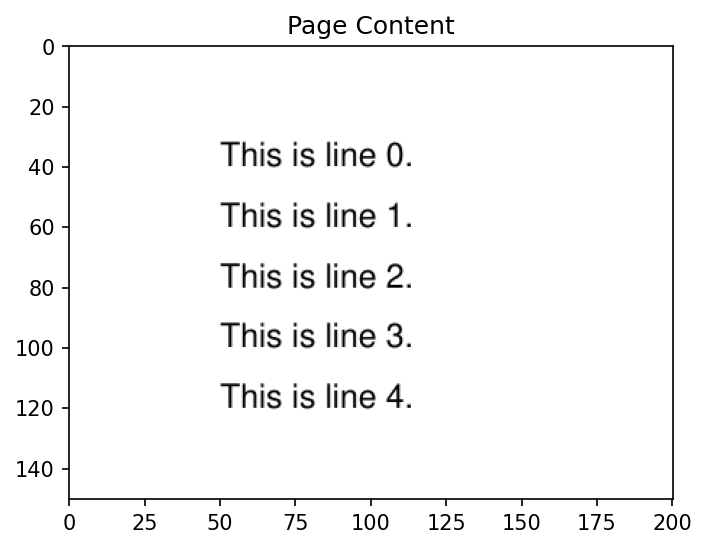

In [10]:
# Display the page image
show_image(page, "Page Content")

Undo the current operation and display the journalling status as above.

In [11]:
doc.journal_undo()  # undo an operation
doc.journal_position()  # where are we in the journal?

(5, 6)

In [12]:
doc.journal_can_do()  # what can we do now?

{'undo': True, 'redo': True}

So, again as expected:
1. Our current position inside the journal is reduced by one - but there are still all six entries in it.
2. We can do both: *undo* **and** *redo*.

The really interesting thing: what happened to the page content?

If all worked fine, we should see only 4 lines of text.

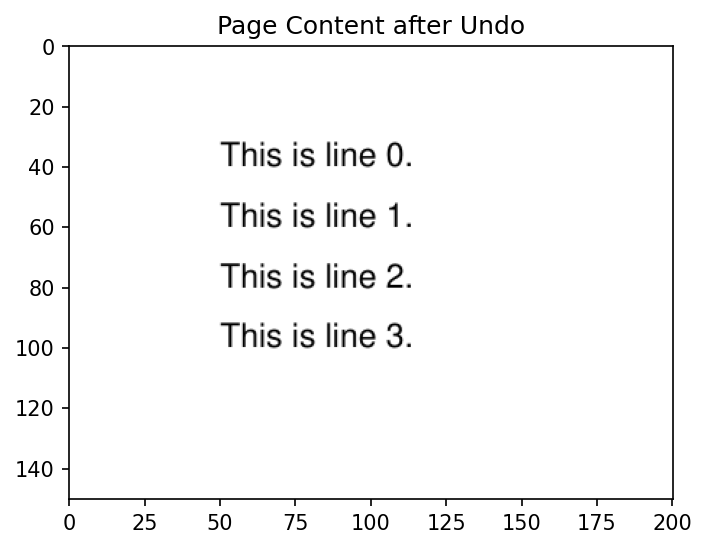

In [13]:
# Display the page image
show_image(page, "Page Content after Undo")

Good! Last text insertion was reverted.

Let us change our mind again and redo (re-apply) the undone operation. This will re-execute everything contained in the operation following the current one. In other words, our fifth text line should reappear.

In [14]:
doc.journal_redo()  # redo reverted operation

True

Confirm that we have five text lines again:

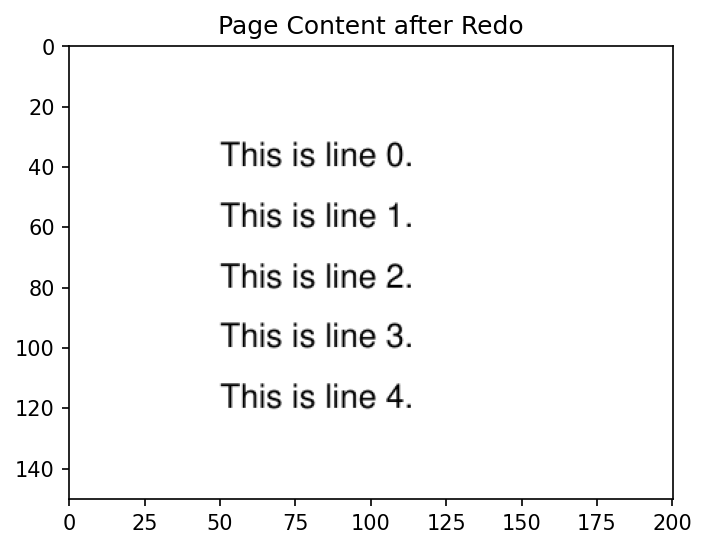

In [15]:
show_image(page, "Page Content after Redo")

We have learned so far, that undoing and redoing uses the journal like a playbook to change the PDF. These actions **do not change the journal** itself.

However if, after some undos, **new operations** are executed, all journal entries will be **deleted that follow the current position**, and the new operations recorded. Look at the following example.

We undo the last three operations (i.e. delete the last three lines) and then draw a rectangle as a new operation.

In [16]:
for i in range(3):  # revert last three operations
    doc.journal_undo()
pos, count = doc.journal_position()
print(f"journal position: {pos}")
print(f"operations count: {count} (unchanged)")

journal position: 3
operations count: 6 (unchanged)


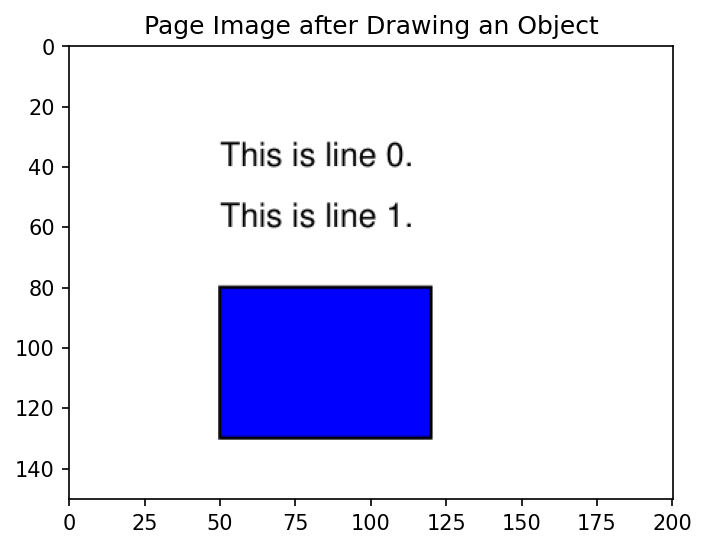

In [17]:
# draw rectangle
doc.journal_start_op("draw rectangle")
page.draw_rect((50, 80, 120, 130), fill=fitz.pdfcolor["blue"])
doc.journal_stop_op()

show_image(page, "Page Image after Drawing an Object")

Also look what happened to the journal:

In [18]:
pos, count = doc.journal_position()
print(f"journal position: {pos}")
print(f"operations count: {count}")
print("\nList of operations:")
for i in range(count):
    print(f"Operation {i}: {doc.journal_op_name(i)}")

journal position: 4
operations count: 4

List of operations:
Operation 0: add new page
Operation 1: add line-0
Operation 2: add line-1
Operation 3: draw rectangle


### Wrapping up

* The journal is kept inside a memory area maintained by MuPDF.
* The journal remains available until the PDF is closed.
* Once enabled, journalling of a PDF cannot be disabled again.
* Journal data can be exported to a file (or file-like object).
* "Undo" reverts the operation at the current position. If current position is the top of the journal, an exception is raised.
* "Redo" re-executes the operation following the current position. If current position is at the end of the journal, an exception is raised.
* Executing operations after an undo removes all journal entries following the current position.


### Conclusion
In this notebook we have learned the basics about PDF journalling:

* How to enable journalling for a PDF
* How to extract journal information
* How to navigate in the journal and undo or redo operations

### Outlook
This notebook is the first of a series about PDF journalling. There is the following sequel:

**Part 2:** The notebook will cover journalling updates to an **existing PDF**, synchronized saving of journal and PDF, and how to enable journalling for a PDF by using a journal file. Please find this notebook [here](https://github.com/pymupdf/PyMuPDF-Utilities/blob/master/jupyter-notebooks/journalling2.ipynb).